In [1]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


## Load in reference data, normalized and cell type + sample corrected

In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location/multi_ref_annot'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map/N2_alpha200'

In [4]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                                      
         /home/ssobti/projects/farnaz_spatial/output_data/cell2location/multi_ref_annot/reference_signatures/model.
         pt already downloaded                                                                                     


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/69:   1%|▏         | 1/69 [00:01<01:43,  1.53s/it, v_num=1, elbo_train=1.64e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/69:   1%|▏         | 1/69 [00:01<01:44,  1.53s/it, v_num=1, elbo_train=1.64e+9]


In [5]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]



Adipocyte_progenitors  Adipocytes   B_cells  Brown_adipocytes  \
Xkr4                 0.856888    1.333403  0.000017          0.001237   
Sox17                0.000777    0.000151  0.000249          0.002336   
Mrpl15               0.126718    0.252087  0.043601          2.367598   
Lypla1               0.080591    0.257422  0.027917          1.354572   
Tcea1                0.185279    0.276333  0.027876          0.882814   

        Endothelial_cells  
Xkr4             0.012203  
Sox17            1.495620  
Mrpl15           0.171279  
Lypla1           0.146360  
Tcea1            0.317588

In [6]:
inf_aver

Adipocyte_progenitors  Adipocytes   B_cells  Brown_adipocytes  \
Xkr4                  0.856888    1.333403  0.000017          0.001237   
Sox17                 0.000777    0.000151  0.000249          0.002336   
Mrpl15                0.126718    0.252087  0.043601          2.367598   
Lypla1                0.080591    0.257422  0.027917          1.354572   
Tcea1                 0.185279    0.276333  0.027876          0.882814   
...                        ...         ...       ...               ...   
Ccr8                  0.000044    0.000173  0.000103          0.004542   
Ccdc152               0.039889    2.767001  0.000177          0.022622   
Fbxo40                0.000094    0.000646  0.000328          0.001754   
Extl1                 0.000188    0.000174  0.003647          0.004905   
S100g                 0.001088    0.003226  0.000275          0.104064   

         Endothelial_cells  Eosinophils  Epithelial_cells  \
Xkr4              0.012203     0.001720          0.447235   
Sox17             1.495620     0.007271          0.000531   
Mrpl15            0.171279     0.016527          0.290706   
Lypla1            0.146360     0.025678          0.302260   
Tcea1             0.317588     0.009997          0.285317   
...                    ...          ...               ...   
Ccr8              0.000237     0.001324          0.000398   
Ccdc152           0.008079     0.001701          0.000231   
Fbxo40            0.001043     0.000819          0.002556   
Extl1             0.000550     0.001639          0.274074   
S100g             0.004959     0.002940          0.008753   

         Lymphatic_endothelial_cells  Macrophages  Mast_cells  Mesothelium  \
Xkr4                        0.027294     0.000071    0.014462     2.877686   
Sox17                       0.011183     0.000270    0.007895     0.000698   
Mrpl15                      0.226614     0.145973    0.031073     0.169864   
Lypla1                      0.217248     0.085147    0.065710     0.182940   
Tcea1                       0.355022     0.194744    0.039495     0.207420   
...                              ...          ...         ...          ...   
Ccr8                        0.001047     0.000055    0.013905     0.000485   
Ccdc152                     0.046807     0.141066    0.013182     0.001394   
Fbxo40                      0.001625     0.006626    0.007780     0.000163   
Extl1                       0.001722     0.001000    0.033688     0.050081   
S100g                       0.002368     0.004545    0.070094     0.000349   

         NK_cells  Neutrophils  Pericytes  Schwan_cells  Skeletal_muscle  \
Xkr4     0.000116     0.000547   0.231026      0.032447         0.012408   
Sox17    0.001067     0.001689   0.003726      0.002905         0.012651   
Mrpl15   0.041783     0.001560   0.110467      0.065814         0.327648   
Lypla1   0.031676     0.016715   0.099241      0.052962         0.234781   
Tcea1    0.019747     0.002272   0.144656      0.183290         0.203325   
...           ...          ...        ...           ...              ...   
Ccr8     0.000432     0.000620   0.000967      0.000920         0.011439   
Ccdc152  0.000802     0.000587   0.012783      0.005381         0.015925   
Fbxo40   0.000211     0.001157   0.001230      0.000455         2.641539   
Extl1    0.000342     0.000656   0.000934      0.003674         0.088841   
S100g    0.000126     0.000810   0.000591      0.001119         0.027226   

          T_cells     Tregs  Vascular_smooth_muscle  white adipocytes  
Xkr4     0.000030  0.000917                0.909910          7.280010  
Sox17    0.000184  0.006084                0.003812          0.000480  
Mrpl15   0.056897  0.295870                0.306349          0.588513  
Lypla1   0.034007  0.129567                0.169079          0.537039  
Tcea1    0.034260  0.204895                0.364905          0.654891  
...           ...       ...                     ...               ...  
Ccr8     0.004128  0.013304      

In [7]:
adata_ref.uns['mod']['factor_names']

array(['Adipocyte_progenitors', 'Adipocytes', 'B_cells',
       'Brown_adipocytes', 'Endothelial_cells', 'Eosinophils',
       'Epithelial_cells', 'Lymphatic_endothelial_cells', 'Macrophages',
       'Mast_cells', 'Mesothelium', 'NK_cells', 'Neutrophils',
       'Pericytes', 'Schwan_cells', 'Skeletal_muscle', 'T_cells', 'Tregs',
       'Vascular_smooth_muscle', 'white adipocytes'], dtype=object)

In [8]:
adata_ref.varm['means_per_cluster_mu_fg']

means_per_cluster_mu_fg_Adipocyte_progenitors  \
Xkr4                                          0.856888   
Sox17                                         0.000777   
Mrpl15                                        0.126718   
Lypla1                                        0.080591   
Tcea1                                         0.185279   
...                                                ...   
Ccr8                                          0.000044   
Ccdc152                                       0.039889   
Fbxo40                                        0.000094   
Extl1                                         0.000188   
S100g                                         0.001088   

         means_per_cluster_mu_fg_Adipocytes  means_per_cluster_mu_fg_B_cells  \
Xkr4                               1.333403                         0.000017   
Sox17                              0.000151                         0.000249   
Mrpl15                             0.252087                         0.043601   
Lypla1                             0.257422                         0.027917   
Tcea1                              0.276333                         0.027876   
...                                     ...                              ...   
Ccr8                               0.000173                         0.000103   
Ccdc152                            2.767001                         0.000177   
Fbxo40                             0.000646                         0.000328   
Extl1                              0.000174                         0.003647   
S100g                              0.003226                         0.000275   

         means_per_cluster_mu_fg_Brown_adipocytes  \
Xkr4                                     0.001237   
Sox17                                    0.002336   
Mrpl15                                   2.367598   
Lypla1                                   1.354572   
Tcea1                                    0.882814   
...                                           ...   
Ccr8                                     0.004542   
Ccdc152                                  0.022622   
Fbxo40                                   0.001754   
Extl1                                    0.004905   
S100g                                    0.104064   

         means_per_cluster_mu_fg_Endothelial_cells  \
Xkr4                                      0.012203   
Sox17                                     1.495620   
Mrpl15                                    0.171279   
Lypla1                                    0.146360   
Tcea1                                     0.317588   
...                                            ...   
Ccr8                                      0.000237   
Ccdc152                                   0.008079   
Fbxo40                                    0.001043   
Extl1                                     0.000550   
S100g                                     0.004959   

         means_per_cluster_mu_fg_Eosinophils  \
Xkr4                                0.001720   
Sox17                               0.007271   
Mrpl15                              0.016527   
Lypla1                              0.025678   
Tcea1                               0.009997   
...                                      ...   
Ccr8                                0.001324   
Ccdc152                             0.001701   
Fbxo40                              0.000819   
Extl1                               0.001639   
S100g                               0.002940   

         means_per_cluster_mu_fg_Epithelial_cells  \
Xkr4                                     0.447235   
Sox17                                    0.000531   
Mrpl15                                   0.290706   
Lypla1                                   0.302260   
Tcea1                                    0.285317   
...                                           ...   
Ccr8                                     0.000398   
Ccdc152                                  0.000231   
Fbxo40     

## Loading Visium data

In [9]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/ssobti/projects/farnaz_spatial/data/'

In [10]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'visium.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [11]:
adata_vis.uns

OverloadedDict, wrapping:
	{'spatial': {'count-A1': {'images': {'hires': array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       ...,

       [[1.        , 1.        , 1.      

In [12]:
adata_vis.var

feature_types genome   SYMBOL     mt  \
ENSEMBL                                                      
ENSMUSG00000051951  Gene Expression   mm10     Xkr4  False   
ENSMUSG00000025900  Gene Expression   mm10      Rp1  False   
ENSMUSG00000025902  Gene Expression   mm10    Sox17  False   
ENSMUSG00000025903  Gene Expression   mm10   Lypla1  False   
ENSMUSG00000033813  Gene Expression   mm10    Tcea1  False   
...                             ...    ...      ...    ...   
ENSMUSG00000000103  Gene Expression   mm10     Zfy2  False   
ENSMUSG00000069036  Gene Expression   mm10      Sry  False   
ENSMUSG00000102053  Gene Expression   mm10   Gm4064  False   
ENSMUSG00000096520  Gene Expression   mm10   Gm3376  False   
ENSMUSG00000096686  Gene Expression   mm10  Gm20830  False   

                    n_cells_by_counts-count-A1  mean_counts-count-A1  \
ENSEMBL                                                                
ENSMUSG00000051951                           8              0.002927   
ENSMUSG00000025900                           1              0.000366   
ENSMUSG00000025902                         585              0.252470   
ENSMUSG00000025903                        2141              1.993414   
ENSMUSG00000033813                        1660              1.022320   
...                                        ...                   ...   
ENSMUSG00000000103                           0              0.000000   
ENSMUSG00000069036                           0              0.000000   
ENSMUSG00000102053                           0              0.000000   
ENSMUSG00000096520                           0              0.000000   
ENSMUSG00000096686                           0              0.000000   

                    log1p_mean_counts-count-A1  \
ENSEMBL                                          
ENSMUSG00000051951                    0.002923   
ENSMUSG00000025900                    0.000366   
ENSMUSG00000025902                    0.225117   
ENSMUSG00000025903                    1.096414   
ENSMUSG00000033813                    0.704245   
...                                        ...   
ENSMUSG00000000103                    0.000000   
ENSMUSG00000069036                    0.000000   
ENSMUSG00000102053                    0.000000   
ENSMUSG00000096520                    0.000000   
ENSMUSG00000096686                    0.000000   

                    pct_dropout_by_counts-count-A1  total_counts-count-A1  \
ENSEMBL                                                                     
ENSMUSG00000051951                       99.707281                    8.0   
ENSMUSG00000025900                       99.963410                    1.0   
ENSMUSG00000025902                       78.594951                  690.0   
ENSMUSG00000025903                       21.661178                 5448.0   
ENSMUSG00000033813                       39.260885                 2794.0   
...                                            ...                    ...   
ENSMUSG00000000103                      100.000000                    0.0   
ENSMUSG00000069036                      100.000000                    0.0   
ENSMUSG00000102053                      100.000000                    0.0   
ENSMUSG00000096520                      100.000000                    0.0   
ENSMUSG00000096686                      100.000000                    0.0   

                    log1p_total_counts-count-A1  ...  \
ENSEMBL                                          ...   
ENSMUSG00000051951                     2.197225  ...   
ENSMUSG00000025900                     0.693147  ...   
ENSMUSG00000025902                     6.538140  ...   
ENSMUSG00000025903                     8.603188  ...   
ENSMUSG00000033813                     7.935587  ...   
...                                         ...  ...   
ENSMUSG00000000103                     0.000000  ...   
ENSMUSG00000069036                     0.000000  ...   
ENSMUSG00000102053                     0.000000  ...   
ENSMUSG00

In [13]:
adata_vis.obs

in_tissue  array_row  array_col    sample  \
spot_id                                                                  
count-A1_AAACAAGTATCTCCCA-1          1         50        102  count-A1   
count-A1_AAACACCAATAACTGC-1          1         59         19  count-A1   
count-A1_AAACAGCTTTCAGAAG-1          1         43          9  count-A1   
count-A1_AAACAGGGTCTATATT-1          1         47         13  count-A1   
count-A1_AAACAGTGTTCCTGGG-1          1         73         43  count-A1   
...                                ...        ...        ...       ...   
count-D1_TTGTTAGCAAATTCGA-1          1         22         42  count-D1   
count-D1_TTGTTCAGTGTGCTAC-1          1         24         64  count-D1   
count-D1_TTGTTTCACATCCAGG-1          1         58         42  count-D1   
count-D1_TTGTTTCCATACAACT-1          1         45         27  count-D1   
count-D1_TTGTTTGTGTAAATTC-1          1          7         51  count-D1   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
spot_id                                                                   
count-A1_AAACAAGTATCTCCCA-1               3976                 8.288283   
count-A1_AAACACCAATAACTGC-1               4429                 8.396155   
count-A1_AAACAGCTTTCAGAAG-1               1826                 7.510431   
count-A1_AAACAGGGTCTATATT-1               2560                 7.848153   
count-A1_AAACAGTGTTCCTGGG-1               4224                 8.348775   
...                                        ...                      ...   
count-D1_TTGTTAGCAAATTCGA-1               3821                 8.248529   
count-D1_TTGTTCAGTGTGCTAC-1               2552                 7.845024   
count-D1_TTGTTTCACATCCAGG-1                730                 6.594413   
count-D1_TTGTTTCCATACAACT-1               1768                 7.478170   
count-D1_TTGTTTGTGTAAATTC-1               3685                 8.212297   

                             total_counts  log1p_total_counts  \
spot_id                                                         
count-A1_AAACAAGTATCTCCCA-1       10597.0            9.268420   
count-A1_AAACACCAATAACTGC-1       14374.0            9.573246   
count-A1_AAACAGCTTTCAGAAG-1        3311.0            8.105308   
count-A1_AAACAGGGTCTATATT-1        5105.0            8.538172   
count-A1_AAACAGTGTTCCTGGG-1       13278.0            9.493939   
...                                   ...                 ...   
count-D1_TTGTTAGCAAATTCGA-1        8888.0            9.092570   
count-D1_TTGTTCAGTGTGCTAC-1        4844.0            8.485703   
count-D1_TTGTTTCACATCCAGG-1         970.0            6.878326   
count-D1_TTGTTTCCATACAACT-1        3037.0            8.018954   
count-D1_TTGTTTGTGTAAATTC-1        8191.0            9.010913   

                             pct_counts_in_top_50_genes  \
spot_id                                                   
count-A1_AAACAAGTATCTCCCA-1                   22.421440   
count-A1_AAACACCAATAACTGC-1                   24.356477   
count-A1_AAACAGCTTTCAGAAG-1                   23.165207   
count-A1_AAACAGGGTCTATATT-1                   22.683643   
count-A1_AAACAGTGTTCCTGGG-1                   28.212080   
...                                                 ...   
count-D1_TTGTTAGCAAATTCGA-1                   19.723222   
count-D1_TTGTTCAGTGTGCTAC-1                   21.717589   
count-D1_TTGTTTCACATCCAGG-1                   24.948454   
count-D1_TTGTTTCCATACAACT-1                   24.135660   
count-D1_TTGTTTGTGTAAATTC-1                   23.049689   

                             pct_counts_in_top_100_genes  \
spot_id                                                    
count-A1_AAACAAGTATCTCCCA-1                    29.470605   
count-A1_AAACACCAATAACTGC-1                    31.904828   
count-A1_AAACAGCTTTCAGAAG-1                    30.927212   
count-A1_AAACAGGGTCTATATT-1                    29.676787   
count-A1_AAACAGTGTTCCTGGG-1                    34.907366   
...                                                  ...

In [14]:
adata_vis.var.set_index('SYMBOL', drop=False, inplace=True)
adata_vis.var.index.name = None

In [15]:
## average or get rid of non-unique gene symbols now that you've gotten rid of ENSEMBL IDs
print('total genes:' + str(len(adata_vis.var.index)))
print('unique genes:' + str(len(np.unique(adata_vis.var.index))))
print('duplicates to make unique:' + str(len(adata_vis.var.index)-len(np.unique(adata_vis.var.index))))


total genes:19465
unique genes:19454
duplicates to make unique:11


In [16]:
adata_vis.var_names_make_unique()

In [17]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [18]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")


## Cell2location spatial mapping

In [19]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=2,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 10486 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11948 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  count-A1  │          0          │
│                     │  count-B1  │          1          │
│                     │  count-C1  │          2          │
│                     │  count-D1  │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3000/3000: 100%|██████████| 3000/3000 [3:54:49<00:00,  4.67s/it, v_num=1, elbo_train=8.22e+7]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [3:54:49<00:00,  4.70s/it, v_num=1, elbo_train=8.22e+7]


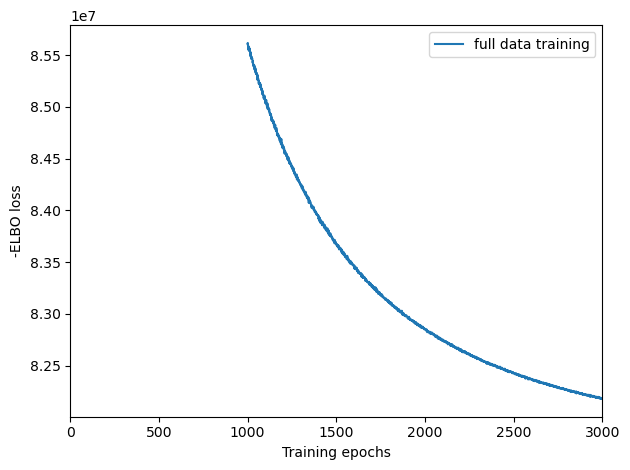

In [20]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [21]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [06:46<00:00,  2.46it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/cell2location/multi_ref_annot/cell2location_map/N2_alpha200/sp.h5ad'

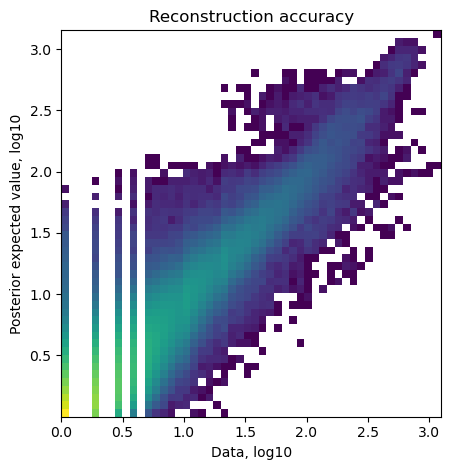

In [22]:
mod.plot_QC()

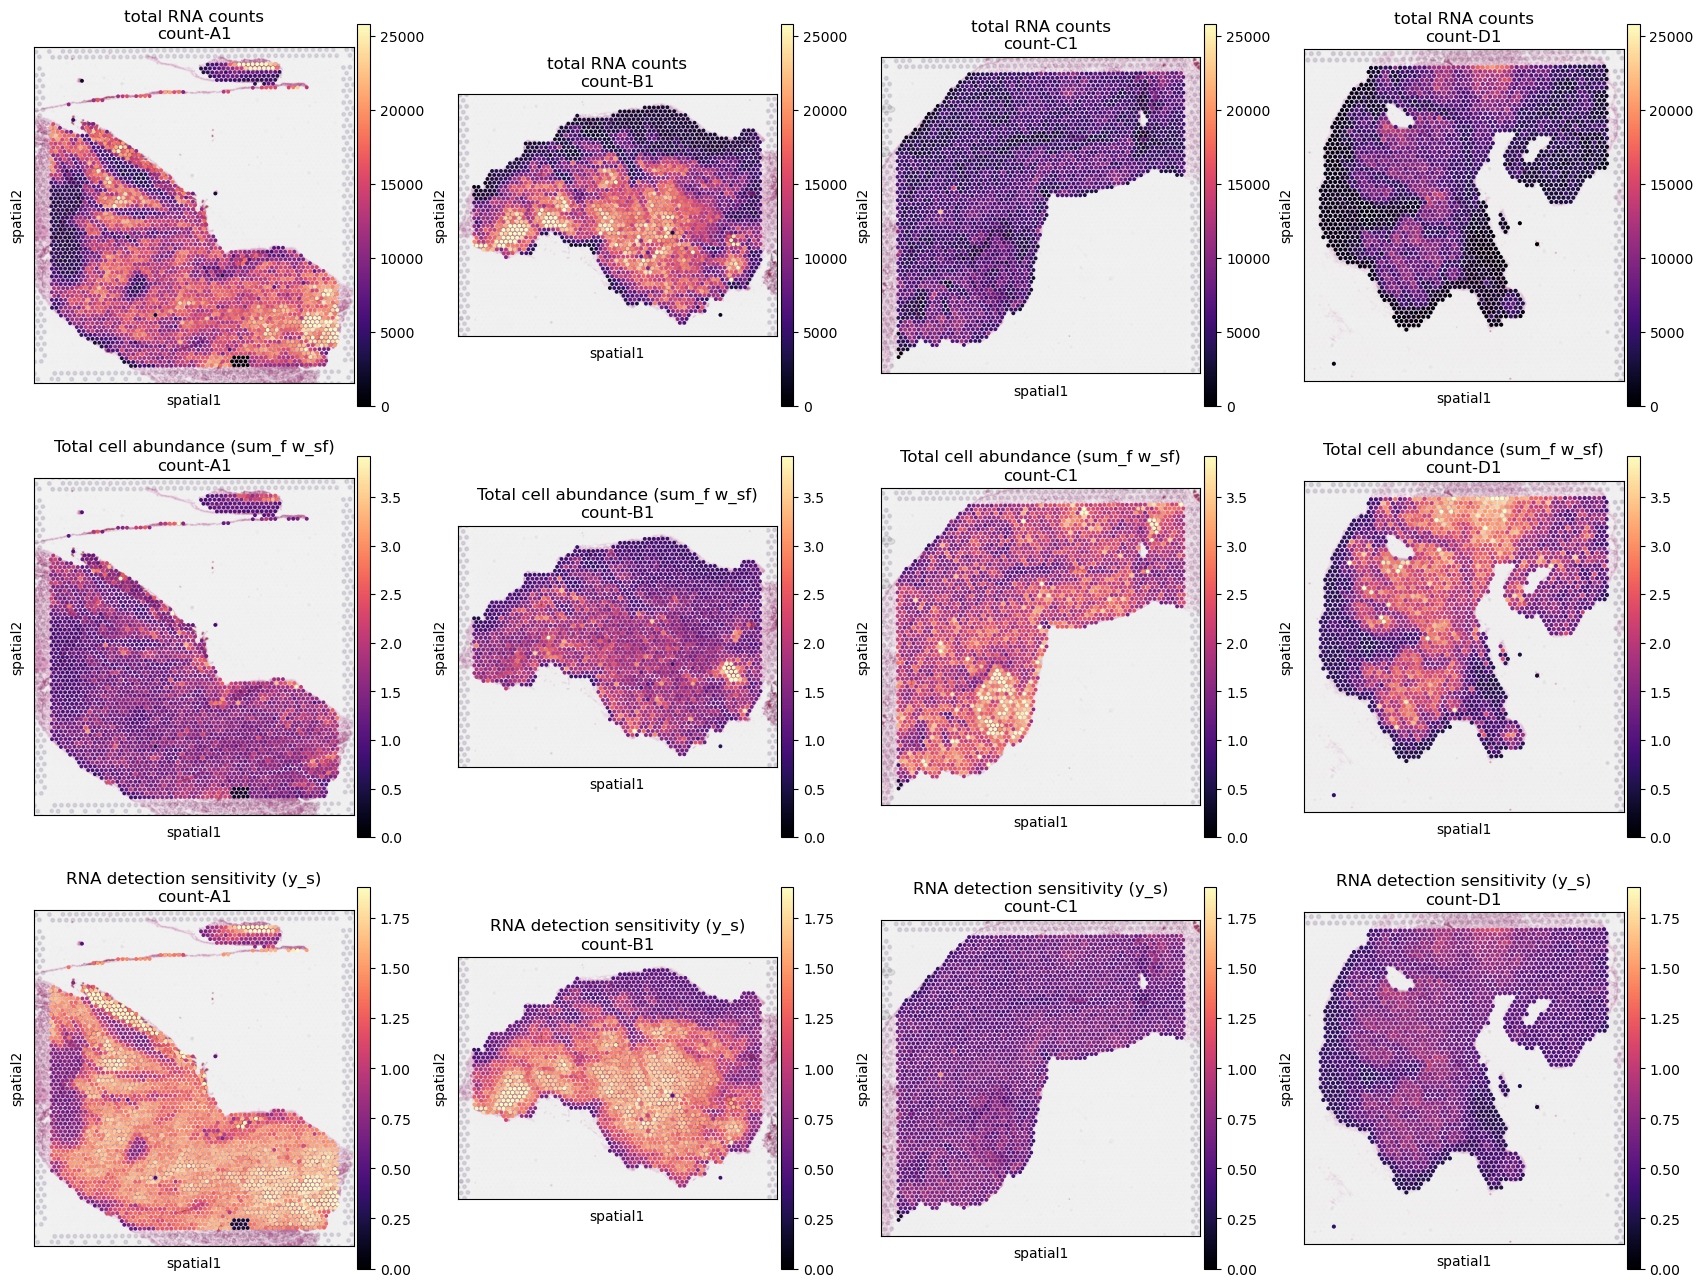

In [23]:
fig = mod.plot_spatial_QC_across_batches()

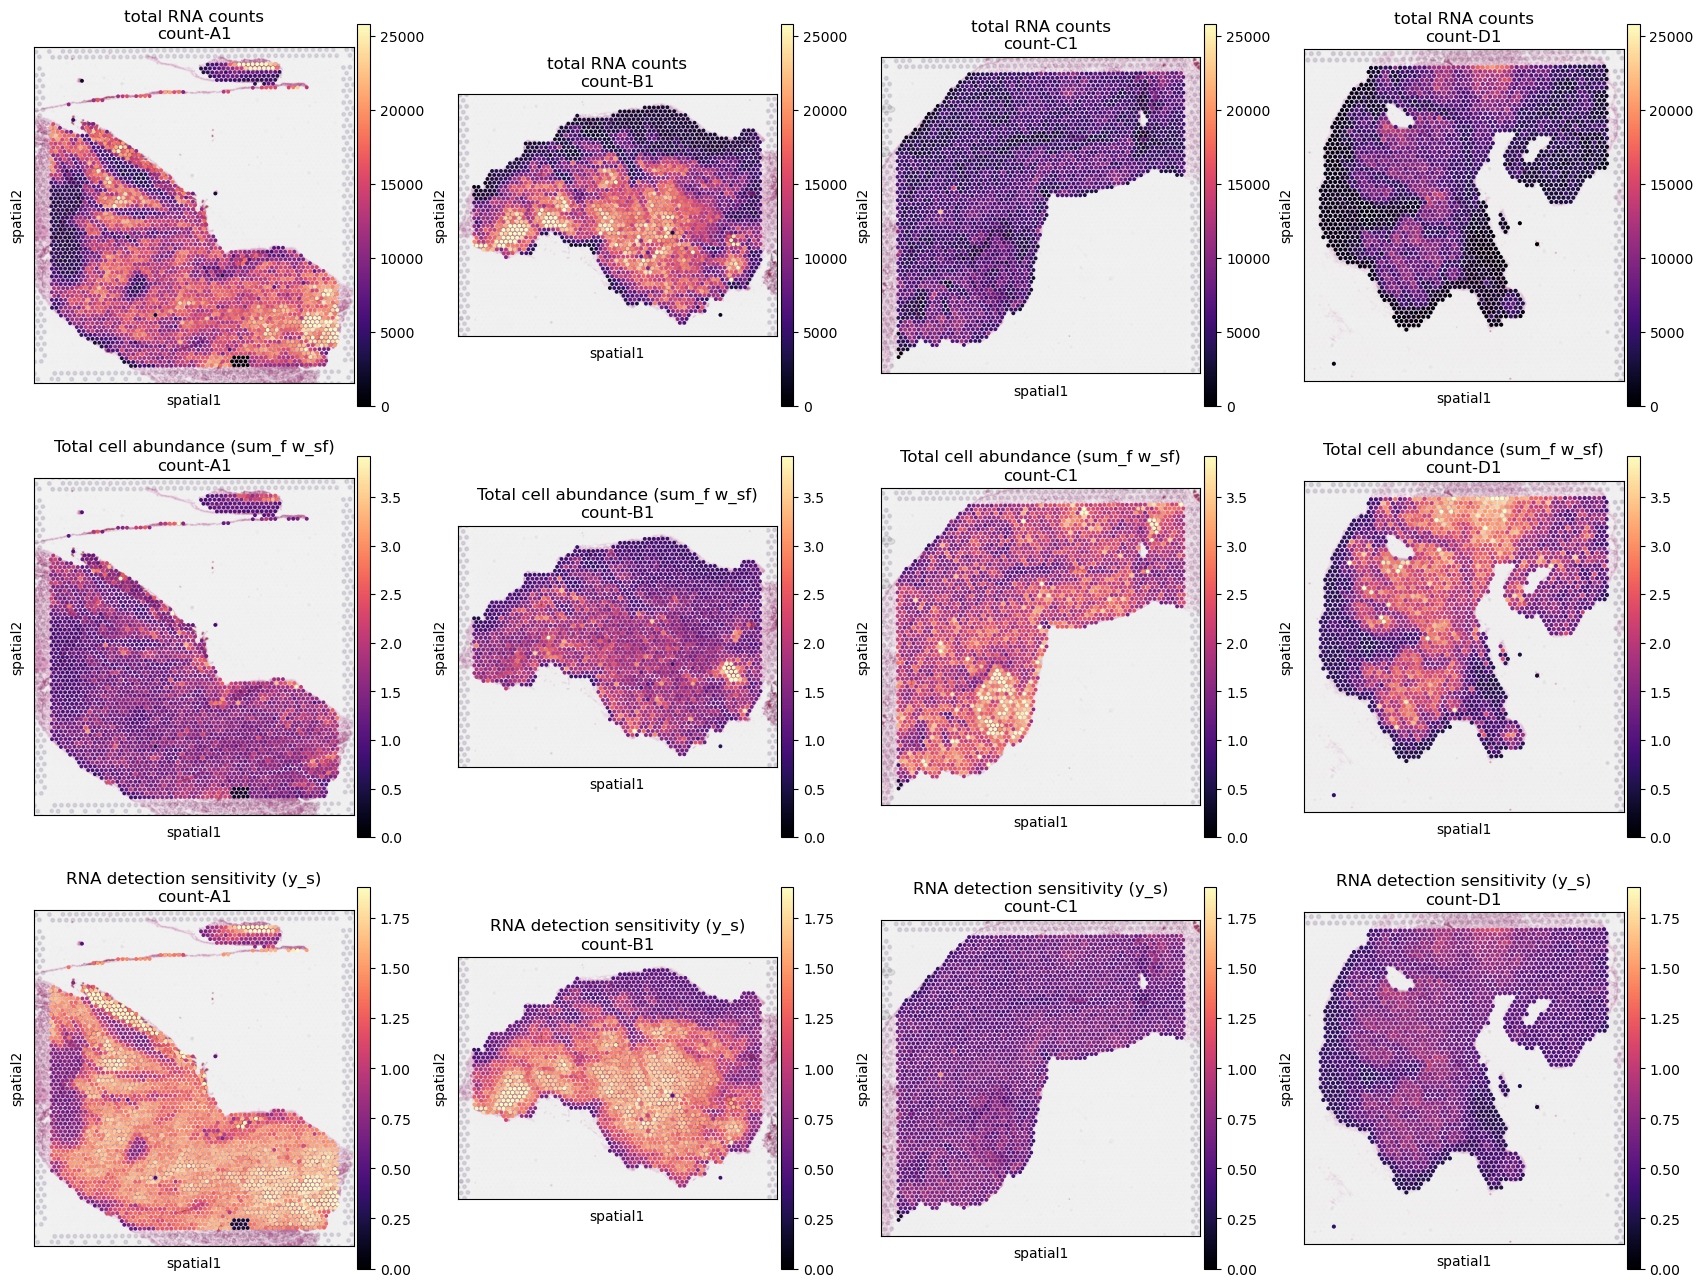

In [24]:
fig